## Classificador de tópicos - Newsgroup

#### Aluno: Willian A. U. Klein

#### Será construído nesse notebook alguns dos conceitos de aprendizagem supervisionada e de classificação. Será usado de classificação multiclasse e suporte a classificadores de maquinas de vetores. O objetivo do algoritmo é procurar um limite de decisão para separar dados de classes diferentes. O algoritmo será implementado com scikit-learn para resolver o problema de de classificação de tópicos de grupos de noticias.

#### Serão usadas tecnicas diferentes para implementação de aprendizado utilizando de SVM para demonstrar algumas difereças de configurações e de desempenho de cada uma das técnicas. Será usado a base de dados do sklearn, fetch_20newsgroups.

#### Os links para o projejeto: 
#### Git: https://github.com/WillianAUK/Classificador-de-Topicos-SVM.git
#### G. Drive: https://drive.google.com/drive/folders/1KzCnRwybajymIxspWiWLwc_PGQGr6tmZ?usp=sharing



#### Primeiramente importando as bibliotecas que serão utilizadas ao decorrer do projeto:

In [1]:
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer
import glob
import os
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import timeit
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

#### Alguns passos e funções pré-escritas que auxiliam na limpeza dos dados: 

In [2]:
all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

In [3]:
def letters_only(astr):
    for c in astr:
        if not c.isalpha():
            return False
    return True

def clean_text(docs):
    cleaned_docs = []
    for doc in docs:
        cleaned_docs.append(' '.join([lemmatizer.lemmatize(word.lower())
                                        for word in doc.split()
                                        if letters_only(word)
                                        and word not in all_names]))
    return cleaned_docs

### Primeiro, será carregado o subconjunto de treinamento e teste dos gráficos de computador e dados de newsgroup do sklearn:

In [4]:
# Carregando o conjunto de dados 20newsgroups

categories = None
data_train = fetch_20newsgroups(subset='train', categories=categories, random_state=42)
data_test = fetch_20newsgroups(subset='test', categories=categories, random_state=42)

In [5]:
# limpamos o conjunto de dados com os 20 grupos inteiros do conjunto de dados

cleaned_train = clean_text(data_train.data)
label_train = data_train.target
cleaned_test = clean_text(data_test.data)
label_test = data_test.target

In [6]:
# Em seguida, extraímos os recursos tf-idf dos dados de texto limpos

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=None)
term_docs_train = tfidf_vectorizer.fit_transform(cleaned_train)
term_docs_test = tfidf_vectorizer.transform(cleaned_test)

### Classificando tópicos de grupos de noticias com SVMs

In [7]:
# Usando o kernel linear pois sabemos que é bom em classificar dados de texto, 
# assim usando "linear" como o valor do hiperparâmetro do kernel e 
# desse modo ficando somente "C" para se ajustar:

svc_libsvm = SVC(kernel='linear')

In [8]:
# Agora vamos especificar o hiperparâmetro (s) para sintonizar 
# e os valores a se explorar para cada hiperparâmetro individual:

parameters = {'C': (0.1, 1, 10, 100)}
grid_search = GridSearchCV(svc_libsvm, parameters, n_jobs=-1, cv=5)

In [9]:
# Execuatndo o ajuste de hiperparâmetros aplicando o 
# método de ajuste e registrando o tempo de execução:

start_time = timeit.default_timer()
grid_search.fit(term_docs_train, label_train)
print("Tempo de execução: %0.2f segundos " % (timeit.default_timer() - start_time))

Tempo de execução: 737.16 segundos 


In [10]:
# Obtendo o conjunto ideal de parâmetros (o C ideal):

grid_search.best_params_

{'C': 10}

In [11]:
# Obtendo o melhor desempenho médio de cinco vezes sob o conjunto ideal de parâmetros:

grid_search.best_score_

0.8826239044045738

In [12]:
# Recuperando o modelo SVM com o hiperparâmetro ideal e o aplicando 
# ao conjunto de teste:

svc_libsvm_best = grid_search.best_estimator_
accuracy = svc_libsvm_best.score(term_docs_test, label_test)
print('A precisão da classificação de 20 classes é de {0:.2f}%'.format(accuracy*100))

A precisão da classificação de 20 classes é de 77.63%


### Repetindo o processo anterior mas agora usando LinearSVC
#### LinearSVC é semelhante ao SVC com kernels lineares, mas é implementado com base na Biblioteca liblinear, que é melhor otimizada do que libsvm com kernel linear.

In [13]:
# Especificando valores a se explorar  basenado em LinearSVC para cada hiperparâmetro individual:

svc_linear = LinearSVC()
grid_search = GridSearchCV(svc_linear, parameters, n_jobs=-1, cv=5)

In [14]:
# Execuatndo o ajuste de hiperparâmetros aplicando o 
# método de ajuste e registrando o tempo de execução:

start_time = timeit.default_timer()
grid_search.fit(term_docs_train, label_train)
print("Tempo de execução: %0.2f segundos" % (timeit.default_timer() - start_time))

Tempo de execução: 50.12 segundos


In [15]:
# Obtendo o conjunto ideal de parâmetros (o C ideal):

grid_search.best_params_

{'C': 1}

In [16]:
# Obtendo o melhor desempenho médio de cinco vezes sob o conjunto ideal de parâmetros:

grid_search.best_score_

0.8913742115991191

In [17]:
# Recuperando o modelo SVM com o hiperparâmetro ideal e o aplicando 
# ao conjunto de teste:

svc_libsvm_best = grid_search.best_estimator_
accuracy = svc_libsvm_best.score(term_docs_test, label_test)
print('A precisão da classificação com 20 classes é de {0:.2f}%'.format(accuracy*100))

A precisão da classificação com 20 classes é de 79.78%


### Agora repetiremos o processo, mas ajustando o extrator de recursos TfidfVectorizer para melhorar o desempenho. 

#### Os parametros na pipeline são:
#### max_df: a frequência máxima de documento de um termo a ser permitida, a fim deevite termos comuns que geralmente ocorrem em documentos
#### max_features: o número dos principais recursos a serem considerados
#### sublinear_tf: quer escalar a frequência do termo com a função logaritmo ou não
#### smooth_idf: Adicionando um 1 inicial à frequência do documento ou não, semelhante afator de suavização para o termo frequência

In [18]:
# O extrator de recursos tfidf e o classificador SVM linear são montados
# primeiro no pipeline:

pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),('svc', LinearSVC()),])

In [19]:
# Os hiperparâmetros a serem ajustados são definidos da seguinte maneira, 
# com um nome de etapa de pipeline unido a um nome de parâmetro por um __ 
# como a chave e uma tupla de opções correspondentes como o valor:

parameters_pipeline = {'tfidf__max_df': (0.25, 0.5, 1.0),
                       'tfidf__max_features': (10000, None),
                       'tfidf__sublinear_tf': (True, False),
                       'tfidf__smooth_idf': (True, False),
                       'svc__C': (0.3, 1, 3), }

In [20]:
# O modelo de pesquisa de grade vai buscar o conjunto ideal de parâmetros 
# em todo o pipeline e o tempo que levará para isso será contabilizado:

grid_search = GridSearchCV(pipeline, parameters_pipeline, n_jobs=-1, cv=5)
start_time = timeit.default_timer()
grid_search.fit(cleaned_train, label_train)
print("-Tempo de execução: %0.2f segundos" % (timeit.default_timer() - start_time))

-Tempo de execução: 537.98 segundos


In [21]:
# Obtendo o conjunto ideal de parâmetros (o C ideal):

grid_search.best_params_

{'svc__C': 1,
 'tfidf__max_df': 0.5,
 'tfidf__max_features': None,
 'tfidf__smooth_idf': False,
 'tfidf__sublinear_tf': True}

In [22]:
# Obtendo o melhor desempenho médio de cinco vezes sob o conjunto ideal de parâmetros:

grid_search.best_score_

0.8986215413996662

In [23]:
# Recuperando o modelo SVM com o hiperparâmetro ideal e o aplicando 
# ao conjunto de teste:

pipeline_best = grid_search.best_estimator_
accuracy = pipeline_best.score(cleaned_test, label_test)
print('A precisão da classificação de 20 classes é de {0:.2f}%'.format(accuracy*100))

A precisão da classificação de 20 classes é de 80.56%


## Considerações:

#### Podemos observar ao longo das abordagens diferentes resultados, nos mostrando que é possível se otimizar tanto em tempo quanto em precisão. Abaixo os resultados obtidos

#### SVM                                 | Tempo de execução: 737.16 segundos    Precisão na classificação: 77.63%
#### LinearSVM                      | Tempo de execução: 50.12 segundos      Precisão na classificação: 79.78%
#### SVM + TfidfVectorizer    | Tempo de execução: 537.98 segundos    Precisão na classificação: 80.56%

#### Podemos vizualizar graficamente os resultados abaixo:

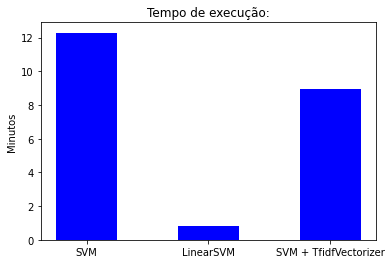

In [61]:
# Plotando o grafico de tempo de execução:

valores = [(737.16/60),(50.12/60),(537.98/60)]

x1 =  np.arange(len(valores))
plt.bar(x1, valores, width=0.5, label = 'Tempo', color = 'b')
grupos = ['SVM', 'LinearSVM', 'SVM + TfidfVectorizer']
plt.xticks([x for x in range(len(valores))], grupos)
plt.title("Tempo de execução:")
plt.ylabel('Minutos')
plt.show()

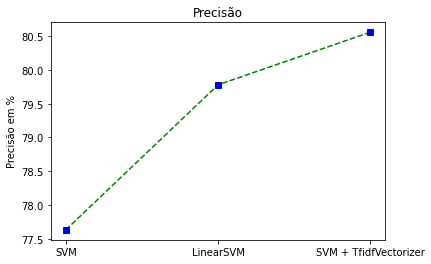

In [63]:
# Plotando o gráfico de Precisão:
grupos = ['SVM', 'LinearSVM', 'SVM + TfidfVectorizer']

plt.plot([0, 1, 2], [77.63, 79.78, 80.56], 'g--')
plt.plot([0, 1, 2], [77.63, 79.78, 80.56], 'bs')
plt.xticks([x  for x in range(3)], grupos)
plt.ylabel('Precisão em %')
plt.title("Precisão")
plt.show()

## Conclusão:
#### Podemos ver com os resultados obtidos que usando SVM com kernel linear podemos obter um valor satisfatório de precisão. De acordo a demanda e a exigencia temos possibilidades de implementação que podem ser mais precisas ou mais rapidas em sua exucução.
#### Para se aprofundar mais e buscar uma maior precisão, podemos trabalhar com o Kernel, implementar abordagens para o um C mais otimizado, mas sempre é preciso levar em consideração o preço do tempo que será cobrado para ser ou não viável. É preciso ficar atento aos efeitos de underfitting e overfiting para não afetarem o resultado ideal.